In [1]:
import os.path as osp

import torch
from tqdm import tqdm
import numpy as np

from torch_geometric.nn import LightGCN
from torch_geometric.utils import degree, train_test_split_edges

In [2]:
import os
import os.path as osp
from typing import Callable, Optional

import pandas as pd
from torch_geometric.data import HeteroData, InMemoryDataset, download_url, extract_zip

class MovieLens100K(InMemoryDataset):
    url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        force_reload: bool = False,
    ):
        super().__init__(root, transform, pre_transform, force_reload=force_reload)
        self.load(self.processed_paths[0], data_cls=HeteroData)

    @property
    def raw_file_names(self) -> list:
        return ['u.item', 'u.user', 'u1.base', 'u1.test']

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self) -> None:
        path = download_url(self.url, self.root)
        extract_zip(path, self.root)
        os.remove(path)
        folder = osp.join(self.root, 'ml-100k')
        os.rename(folder, self.raw_dir)

    def process(self) -> None:
        data = HeteroData()

        # Process users:
        user_df = pd.read_csv(
            osp.join(self.raw_dir, 'u.user'),
            sep='|',
            header=None,
            names=['userId', 'age', 'gender', 'occupation', 'zipCode'],
            encoding='ISO-8859-1',
        )
        data['user'].num_nodes = len(user_df)

        # Process movies:
        movie_df = pd.read_csv(
            osp.join(self.raw_dir, 'u.item'),
            sep='|',
            header=None,
            names=[
                "movieId", "title", "releaseDate", "videoReleaseDate", "IMDb URL",
                "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
                "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
                "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
            ],
            encoding='ISO-8859-1',
            usecols=['movieId'],
        )
        data['movie'].num_nodes = len(movie_df)

        # Process edges for training and testing:
        edge_attrs = ['edge_index', 'edge_label_index']
        for edge_attr, raw_path in zip(edge_attrs, ['u1.base', 'u1.test']):
            edges_df = pd.read_csv(
                osp.join(self.raw_dir, raw_path),
                sep='\t',
                header=None,
                names=['userId', 'movieId', 'rating', 'timestamp'],
            )
            src = edges_df['userId'].values - 1  # Adjusting index to start from 0
            dst = edges_df['movieId'].values - 1  # Adjusting index to start from 0
            index = torch.tensor(np.array([src, dst]))
            data['user', 'rates', 'movie'][edge_attr] = index
            if edge_attr == 'edge_index':
                data['movie', 'rated_by', 'user'][edge_attr] = index.flip([0])

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        self.save([data], self.processed_paths[0])


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.dirname(osp.realpath('projectFINAL.ipynb')), '', 'data', 'MovieLens')
dataset = MovieLens100K(path)
data = dataset[0]
num_users, num_movies = data['user'].num_nodes, data['movie'].num_nodes
data = data.to_homogeneous().to(device)
print(data)

Data(edge_index=[2, 160000], edge_label_index=[2, 20000], node_type=[2625], edge_type=[160000])


In [4]:
from torch import Tensor
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import is_sparse, to_edge_index
from typing import List

class ResidualLightGCN(LightGCN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_embeddings_per_layer(
        self,
        edge_index: Adj,
        edge_weight: OptTensor = None,
    ) -> List[Tensor]:
        """Returns the embeddings of nodes in the graph for each layer."""
        x = self.embedding.weight
        embeddings = [x]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, edge_weight)
            embeddings.append(x)

        return embeddings

    def forward(
        self,
        edge_index: Adj,
        edge_label_index: OptTensor = None,
        edge_weight: OptTensor = None,
    ) -> Tensor:
        r"""Computes rankings for pairs of nodes.

        Args:
            edge_index (torch.Tensor or SparseTensor): Edge tensor specifying
                the connectivity of the graph.
            edge_label_index (torch.Tensor, optional): Edge tensor specifying
                the node pairs for which to compute rankings or probabilities.
                If :obj:`edge_label_index` is set to :obj:`None`, all edges in
                :obj:`edge_index` will be used instead. (default: :obj:`None`)
            edge_weight (torch.Tensor, optional): The weight of each edge in
                :obj:`edge_index`. (default: :obj:`None`)
        """
        if edge_label_index is None:
            if is_sparse(edge_index):
                edge_label_index, _ = to_edge_index(edge_index)
            else:
                edge_label_index = edge_index

        embeddings = self.get_embeddings_per_layer(edge_index, edge_weight)

        pred = torch.zeros(edge_label_index.size(1), device=edge_index.device)
        for i, alpha in enumerate(self.alpha):
            out_src = embeddings[i][edge_label_index[0]]
            out_dst = embeddings[i][edge_label_index[1]]
            pred += alpha * (out_src * out_dst).sum(dim=-1)

        return pred
    
    def recommend(
        self,
        edge_index: Adj,
        edge_weight: OptTensor = None,
        src_index: OptTensor = None,
        dst_index: OptTensor = None,
        k: int = 1,
        sorted: bool = True,
    ) -> Tensor:
        r"""Get top-:math:`k` recommendations for nodes in :obj:`src_index`.

        Args:
            edge_index (torch.Tensor or SparseTensor): Edge tensor specifying
                the connectivity of the graph.
            edge_weight (torch.Tensor, optional): The weight of each edge in
                :obj:`edge_index`. (default: :obj:`None`)
            src_index (torch.Tensor, optional): Node indices for which
                recommendations should be generated.
                If set to :obj:`None`, all nodes will be used.
                (default: :obj:`None`)
            dst_index (torch.Tensor, optional): Node indices which represent
                the possible recommendation choices.
                If set to :obj:`None`, all nodes will be used.
                (default: :obj:`None`)
            k (int, optional): Number of recommendations. (default: :obj:`1`)
            sorted (bool, optional): Whether to sort the recommendations
                by score. (default: :obj:`True`)
        """
        embeddings = self.get_embeddings_per_layer(edge_index, edge_weight)

        out_src = out_dst = sum(alpha * emb for alpha, emb in zip(self.alpha, embeddings))

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1, sorted=sorted).indices

        if dst_index is not None:
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


In [5]:
# Split edges into train/val/test sets
data = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.1)
print(data)

train_edge_index = data.train_pos_edge_index
val_edge_index = data.val_pos_edge_index
test_edge_index = data.test_pos_edge_index

batch_size = 512
mask = train_edge_index[0] < train_edge_index[1]
train_edge_label_index = train_edge_index[:, mask]
train_loader = torch.utils.data.DataLoader(
    range(train_edge_label_index.size(1)),
    shuffle=True,
    batch_size=batch_size,
)

model = ResidualLightGCN(
    num_nodes=data.num_nodes,
    embedding_dim=64,
    num_layers=2,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Data(edge_label_index=[2, 20000], node_type=[2625], edge_type=[160000], val_pos_edge_index=[2, 8000], test_pos_edge_index=[2, 8000], train_pos_edge_index=[2, 128000], train_neg_adj_mask=[2625, 2625], val_neg_edge_index=[2, 8000], test_neg_edge_index=[2, 8000])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [12]:
def train():
    model.train()
    total_loss = total_examples = 0

    for index in tqdm(train_loader):
        pos_edge_label_index = train_edge_label_index[:, index]
        neg_edge_label_index = torch.stack([
            pos_edge_label_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (index.numel(), ), device=device)
        ], dim=0)
        edge_label_index = torch.cat([
            pos_edge_label_index,
            neg_edge_label_index,
        ], dim=1)

        optimizer.zero_grad()
        pos_rank, neg_rank = model(data.train_pos_edge_index, edge_label_index).chunk(2)

        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=edge_label_index.unique(),
        )
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pos_rank.numel()
        total_examples += pos_rank.numel()

    return total_loss / total_examples

@torch.no_grad()
def test(edge_index, k: int):
    model.eval()
    embeddings_per_layer = model.get_embeddings_per_layer(data.train_pos_edge_index)
    num_layers = len(embeddings_per_layer)

    emb = sum(model.alpha[i] * embeddings_per_layer[i] for i in range(num_layers))
    user_emb, movie_emb = emb[:num_users], emb[num_users:]

    precision = recall = total_examples = total_loss = 0
    for start in range(0, num_users, batch_size):
        end = start + batch_size
        logits = user_emb[start:end] @ movie_emb.t()

        mask = ((train_edge_label_index[0] >= start) &
                (train_edge_label_index[0] < end))
        logits[train_edge_label_index[0, mask] - start,
               train_edge_label_index[1, mask] - num_users] = float('-inf')

        ground_truth = torch.zeros_like(logits, dtype=torch.bool)
        mask = ((edge_index[0] >= start) & (edge_index[0] < end))
        ground_truth[edge_index[0, mask] - start,
                     edge_index[1, mask] - num_users] = True
        node_count = degree(edge_index[0, mask] - start,
                            num_nodes=logits.size(0))

        topk_index = logits.topk(k, dim=-1).indices
        isin_mat = ground_truth.gather(1, topk_index)

        precision += float((isin_mat.sum(dim=-1) / k).sum())
        recall += float((isin_mat.sum(dim=-1) / node_count.clamp(1e-6)).sum())
        total_examples += int((node_count > 0).sum())

        # Calculate loss
        pos_edge_index = edge_index[:, mask]
        neg_edge_index = torch.stack([
            pos_edge_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (pos_edge_index.size(1),), device=device)
        ], dim=0)
        eval_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)

        pos_rank, neg_rank = model(data.train_pos_edge_index, eval_edge_index).chunk(2)
        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=eval_edge_index.unique(),
        )
        total_loss += float(loss) * pos_rank.numel()

    return total_loss / total_examples, precision / total_examples, recall / total_examples


In [13]:
patience = 10  # Number of epochs to wait for improvement
best_val_recall = 0
best_epoch = 0
patience_counter = 0
best_model_path = 'best_model_ResidualLightGCN.pth'

train_losses = []
val_losses = []

n_epochs = 50

for epoch in range(1, n_epochs + 1):
    loss = train()
    val_loss, val_precision, val_recall = test(val_edge_index, k=20)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Precision@20: '
          f'{val_precision:.4f}, Val Recall@20: {val_recall:.4f}, '
          f'Val Loss: {val_loss:.4f}')
    
    train_losses.append(loss)
    val_losses.append(val_loss)
    
    # Early stopping logic
    if val_recall > best_val_recall:
        best_val_recall = val_recall
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}. Best epoch: {best_epoch} with Val Recall@20: {best_val_recall:.4f}')
        break
    


100%|██████████| 125/125 [00:06<00:00, 17.86it/s]


Epoch: 001, Train Loss: 0.3101, Val Precision@20: 0.0849, Val Recall@20: 0.2503, Val Loss: 2.9345


100%|██████████| 125/125 [00:06<00:00, 18.05it/s]


Epoch: 002, Train Loss: 0.3022, Val Precision@20: 0.0865, Val Recall@20: 0.2549, Val Loss: 2.9296


100%|██████████| 125/125 [00:05<00:00, 22.00it/s]


Epoch: 003, Train Loss: 0.3004, Val Precision@20: 0.0867, Val Recall@20: 0.2569, Val Loss: 2.9607


100%|██████████| 125/125 [00:06<00:00, 20.31it/s]


Epoch: 004, Train Loss: 0.3007, Val Precision@20: 0.0869, Val Recall@20: 0.2537, Val Loss: 2.9104


100%|██████████| 125/125 [00:05<00:00, 20.98it/s]


Epoch: 005, Train Loss: 0.2948, Val Precision@20: 0.0877, Val Recall@20: 0.2589, Val Loss: 2.9457


100%|██████████| 125/125 [00:06<00:00, 18.85it/s]


Epoch: 006, Train Loss: 0.2924, Val Precision@20: 0.0880, Val Recall@20: 0.2613, Val Loss: 2.8759


 23%|██▎       | 29/125 [00:02<00:06, 13.89it/s]


KeyboardInterrupt: 

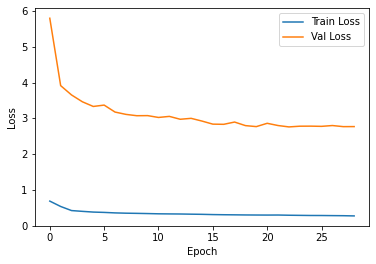

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
model.load_state_dict(torch.load(best_model_path))
test_loss, test_precision, test_recall = test(test_edge_index, k=20)
print(f'Test Precision@20: {test_precision:.4f}, Test Recall@20: {test_recall:.4f}')

Test Precision@20: 0.0890, Test Recall@20: 0.2591


### Train and evaluate regular LightGCN model for comparison

In [14]:
model = LightGCN(
    num_nodes=data.num_nodes,
    embedding_dim=64,
    num_layers=2,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
def train_LightGCN():
    model.train()
    total_loss = total_examples = 0

    for index in tqdm(train_loader):
        pos_edge_label_index = train_edge_label_index[:, index]
        neg_edge_label_index = torch.stack([
            pos_edge_label_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (index.numel(), ), device=device)
        ], dim=0)
        edge_label_index = torch.cat([
            pos_edge_label_index,
            neg_edge_label_index,
        ], dim=1)

        optimizer.zero_grad()
        pos_rank, neg_rank = model(data.train_pos_edge_index, edge_label_index).chunk(2)

        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=edge_label_index.unique(),
        )
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pos_rank.numel()
        total_examples += pos_rank.numel()

    return total_loss / total_examples

@torch.no_grad()
def test_LightGCN(edge_index, k: int):
    model.eval()
    emb = model.get_embedding(data.train_pos_edge_index)
    user_emb, movie_emb = emb[:num_users], emb[num_users:]

    precision = recall = total_examples = total_loss = 0
    for start in range(0, num_users, batch_size):
        end = start + batch_size
        logits = user_emb[start:end] @ movie_emb.t()

        mask = ((train_edge_label_index[0] >= start) &
                (train_edge_label_index[0] < end))
        logits[train_edge_label_index[0, mask] - start,
               train_edge_label_index[1, mask] - num_users] = float('-inf')

        ground_truth = torch.zeros_like(logits, dtype=torch.bool)
        mask = ((edge_index[0] >= start) & (edge_index[0] < end))
        ground_truth[edge_index[0, mask] - start,
                     edge_index[1, mask] - num_users] = True
        node_count = degree(edge_index[0, mask] - start,
                            num_nodes=logits.size(0))

        topk_index = logits.topk(k, dim=-1).indices
        isin_mat = ground_truth.gather(1, topk_index)

        precision += float((isin_mat.sum(dim=-1) / k).sum())
        recall += float((isin_mat.sum(dim=-1) / node_count.clamp(1e-6)).sum())
        total_examples += int((node_count > 0).sum())

        # Calculate loss
        pos_edge_index = edge_index[:, mask]
        neg_edge_index = torch.stack([
            pos_edge_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (pos_edge_index.size(1),), device=device)
        ], dim=0)
        eval_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)

        pos_rank, neg_rank = model(data.train_pos_edge_index, eval_edge_index).chunk(2)
        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=eval_edge_index.unique(),
        )
        total_loss += float(loss) * pos_rank.numel()

    return total_loss / total_examples, precision / total_examples, recall / total_examples


In [18]:
patience = 10  # Number of epochs to wait for improvement
best_val_recall = 0
best_epoch = 0
patience_counter = 0
best_model_path_LightGCN = 'best_model_LightGCN.pth'

train_losses_LightGCN = []
val_losses_LightGCN = []

for epoch in range(1, n_epochs + 1):
    loss = train_LightGCN()
    val_loss, val_precision, val_recall = test_LightGCN(val_edge_index, k=20)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Precision@20: '
          f'{val_precision:.4f}, Val Recall@20: {val_recall:.4f}, '
          f'Val Loss: {val_loss:.4f}')
    
    train_losses_LightGCN.append(loss)
    val_losses_LightGCN.append(val_loss)
    
    # Early stopping logic
    if val_recall > best_val_recall:
        best_val_recall = val_recall
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}. Best epoch: {best_epoch} with Val Recall@20: {best_val_recall:.4f}')
        break
    


100%|██████████| 125/125 [00:06<00:00, 19.97it/s]


Epoch: 001, Train Loss: 0.4511, Val Precision@20: 0.0596, Val Recall@20: 0.1753, Val Loss: 3.7583


100%|██████████| 125/125 [00:06<00:00, 20.80it/s]


Epoch: 002, Train Loss: 0.4085, Val Precision@20: 0.0632, Val Recall@20: 0.1860, Val Loss: 3.7085


100%|██████████| 125/125 [00:05<00:00, 21.64it/s]


Epoch: 003, Train Loss: 0.4019, Val Precision@20: 0.0669, Val Recall@20: 0.2033, Val Loss: 3.6454


100%|██████████| 125/125 [00:05<00:00, 21.47it/s]


Epoch: 004, Train Loss: 0.3891, Val Precision@20: 0.0713, Val Recall@20: 0.2195, Val Loss: 3.5171


100%|██████████| 125/125 [00:05<00:00, 21.86it/s]


Epoch: 005, Train Loss: 0.3764, Val Precision@20: 0.0760, Val Recall@20: 0.2331, Val Loss: 3.4451


100%|██████████| 125/125 [00:05<00:00, 21.81it/s]


Epoch: 006, Train Loss: 0.3666, Val Precision@20: 0.0780, Val Recall@20: 0.2421, Val Loss: 3.3416


100%|██████████| 125/125 [00:05<00:00, 22.13it/s]


Epoch: 007, Train Loss: 0.3597, Val Precision@20: 0.0789, Val Recall@20: 0.2433, Val Loss: 3.3257


100%|██████████| 125/125 [00:05<00:00, 21.77it/s]


Epoch: 008, Train Loss: 0.3519, Val Precision@20: 0.0803, Val Recall@20: 0.2425, Val Loss: 3.2766


100%|██████████| 125/125 [00:05<00:00, 22.95it/s]


Epoch: 009, Train Loss: 0.3457, Val Precision@20: 0.0805, Val Recall@20: 0.2417, Val Loss: 3.2148


100%|██████████| 125/125 [00:05<00:00, 21.81it/s]


Epoch: 010, Train Loss: 0.3404, Val Precision@20: 0.0798, Val Recall@20: 0.2386, Val Loss: 3.1904


100%|██████████| 125/125 [00:06<00:00, 20.43it/s]


Epoch: 011, Train Loss: 0.3371, Val Precision@20: 0.0803, Val Recall@20: 0.2408, Val Loss: 3.0691


100%|██████████| 125/125 [00:06<00:00, 20.67it/s]


Epoch: 012, Train Loss: 0.3342, Val Precision@20: 0.0804, Val Recall@20: 0.2413, Val Loss: 3.0856


100%|██████████| 125/125 [00:06<00:00, 20.78it/s]


Epoch: 013, Train Loss: 0.3345, Val Precision@20: 0.0807, Val Recall@20: 0.2442, Val Loss: 3.0784


100%|██████████| 125/125 [00:05<00:00, 21.14it/s]


Epoch: 014, Train Loss: 0.3252, Val Precision@20: 0.0813, Val Recall@20: 0.2449, Val Loss: 3.1133


100%|██████████| 125/125 [00:05<00:00, 21.34it/s]


Epoch: 015, Train Loss: 0.3244, Val Precision@20: 0.0822, Val Recall@20: 0.2471, Val Loss: 3.0721


100%|██████████| 125/125 [00:05<00:00, 21.29it/s]


Epoch: 016, Train Loss: 0.3210, Val Precision@20: 0.0829, Val Recall@20: 0.2479, Val Loss: 3.0643


100%|██████████| 125/125 [00:05<00:00, 21.18it/s]


Epoch: 017, Train Loss: 0.3184, Val Precision@20: 0.0837, Val Recall@20: 0.2475, Val Loss: 3.0809


100%|██████████| 125/125 [00:05<00:00, 21.75it/s]


Epoch: 018, Train Loss: 0.3155, Val Precision@20: 0.0835, Val Recall@20: 0.2460, Val Loss: 3.0385


100%|██████████| 125/125 [00:05<00:00, 22.01it/s]


Epoch: 019, Train Loss: 0.3113, Val Precision@20: 0.0848, Val Recall@20: 0.2511, Val Loss: 2.9925


100%|██████████| 125/125 [00:05<00:00, 21.11it/s]


Epoch: 020, Train Loss: 0.3075, Val Precision@20: 0.0844, Val Recall@20: 0.2510, Val Loss: 2.9734


100%|██████████| 125/125 [00:05<00:00, 21.14it/s]


Epoch: 021, Train Loss: 0.3065, Val Precision@20: 0.0859, Val Recall@20: 0.2536, Val Loss: 2.9736


100%|██████████| 125/125 [00:07<00:00, 17.21it/s]


Epoch: 022, Train Loss: 0.3007, Val Precision@20: 0.0860, Val Recall@20: 0.2551, Val Loss: 2.9182


100%|██████████| 125/125 [00:06<00:00, 19.83it/s]


Epoch: 023, Train Loss: 0.2980, Val Precision@20: 0.0862, Val Recall@20: 0.2549, Val Loss: 2.9462


100%|██████████| 125/125 [00:05<00:00, 21.22it/s]


Epoch: 024, Train Loss: 0.2973, Val Precision@20: 0.0870, Val Recall@20: 0.2546, Val Loss: 2.9728


100%|██████████| 125/125 [00:05<00:00, 21.48it/s]


Epoch: 025, Train Loss: 0.2953, Val Precision@20: 0.0870, Val Recall@20: 0.2562, Val Loss: 2.8825


100%|██████████| 125/125 [00:05<00:00, 21.09it/s]


Epoch: 026, Train Loss: 0.2941, Val Precision@20: 0.0881, Val Recall@20: 0.2582, Val Loss: 2.8268


100%|██████████| 125/125 [00:05<00:00, 20.99it/s]


Epoch: 027, Train Loss: 0.2937, Val Precision@20: 0.0884, Val Recall@20: 0.2606, Val Loss: 2.8981


100%|██████████| 125/125 [00:06<00:00, 20.42it/s]


Epoch: 028, Train Loss: 0.2919, Val Precision@20: 0.0890, Val Recall@20: 0.2644, Val Loss: 2.8649


100%|██████████| 125/125 [00:06<00:00, 20.71it/s]


Epoch: 029, Train Loss: 0.2913, Val Precision@20: 0.0895, Val Recall@20: 0.2651, Val Loss: 2.8580


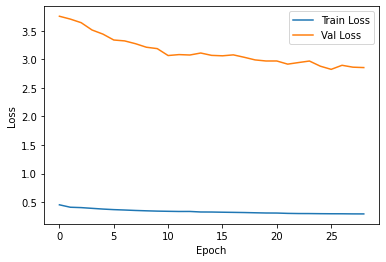

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses_LightGCN, label='Train Loss')
plt.plot(val_losses_LightGCN, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
model.load_state_dict(torch.load(best_model_path_LightGCN))
test_loss, test_precision, test_recall = test_LightGCN(test_edge_index, k=20)
print(f'Test Precision@20: {test_precision:.4f}, Test Recall@20: {test_recall:.4f}')

Test Precision@20: 0.0892, Test Recall@20: 0.2655
